In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
from urllib.request import urlopen
import warnings

from util.munge import max_print, state_abbrevs, state_full_names, palette

warnings.filterwarnings('ignore')

# Goal

Compare data reported within existing county-level data sets (NYT, CDS, CSBS). 

# Get Data

In [2]:
def get_csbs_df():
    response = urlopen("http://coronavirus-tracker-api.herokuapp.com/v2/locations?source=csbs")
    json_data = response.read().decode('utf-8', 'replace')
    d = json.loads(json_data)
    df = json_normalize(d['locations'])
    
    # remove "extras"
    df = df \
        .loc[df["country"] == "US"] \
        .rename(columns={
            "province":"state", 
            "latest.confirmed":"cases",
            "latest.deaths":"deaths",
            "latest.recovered":"recovered"}) \
        .drop(["id","country_population","country","country_code",
            "coordinates.latitude","coordinates.longitude"], axis=1)
    df["source"] = "csbs"
    return df

def get_cds_df():
    cds = pd.read_csv("https://coronadatascraper.com/data.csv")
    cds = cds \
        .loc[(cds["country"] == "USA") & (~cds["county"].isnull())] \
        .drop(["city","country","lat","long","url","maintainers",
            "aggregate","tz","featureId","sources","curators"], axis=1)
        
    cds["state"] = cds["state"].map(state_full_names)
    cds["county"] = cds["county"].apply(lambda x: x.replace("County", "").strip())
    cds["source"] = "cds"
    return cds

def get_nyt_df():
    """The NYT dataset provides a case report each day per county"""
    nyt = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv")
    nyt = nyt.loc[nyt["date"] == nyt["date"].max()]
    nyt["source"] = "nyt"
    return nyt

def get_covid_tracking_state_df():
    states = pd.read_csv("https://covidtracking.com/api/states.csv")
    states["state"] = states["state"].map(state_full_names)
    return states

In [3]:
csbs = get_csbs_df()
cds = get_cds_df()
nyt = get_nyt_df()
states = get_covid_tracking_state_df()

In [4]:
long_df = pd.concat([csbs, cds, nyt], axis=0, sort=False)

In [5]:
wide_df = cds.merge(csbs, how="outer", on=["state", "county"], suffixes=["_csbs","_cds"]) \
    .drop(["source_csbs","source_cds"], axis=1)
wide_df = wide_df.merge(nyt, how="outer", on=["state", "county"]) \
    .drop("source", axis=1) \
    .rename(columns={"cases":"cases_nyt","deaths":"deaths_nyt"})

# Analysis

In [6]:
max_print(csbs.head())

,county,last_updated,cases,deaths,recovered,state,source
0,New York,2020-03-27T23:57:00Z,26697,450,0,New York,csbs
1,Westchester,2020-03-27T23:57:00Z,7187,10,0,New York,csbs
2,Nassau,2020-03-27T23:57:00Z,4657,27,0,New York,csbs
3,Suffolk,2020-03-27T23:57:00Z,3385,30,0,New York,csbs
4,Rockland,2020-03-27T23:57:00Z,1457,8,0,New York,csbs


In [7]:
max_print(cds.head())

,county,state,cases,deaths,recovered,tested,active,population,rating,source
407,Anchorage,Alaska,33.0,0.0,NaN,NaN,NaN,NaN,0.627451,cds
408,Fairbanks North Star Borough,Alaska,15.0,0.0,NaN,NaN,NaN,98971.0,0.627451,cds
409,Juneau City and Borough,Alaska,3.0,0.0,NaN,NaN,NaN,32113.0,0.627451,cds
410,Kenai Peninsula Borough,Alaska,5.0,0.0,NaN,NaN,NaN,58533.0,0.627451,cds
411,Ketchikan Gateway Borough,Alaska,11.0,0.0,NaN,NaN,NaN,13918.0,0.627451,cds


In [8]:
max_print(nyt.head())

,date,county,state,fips,cases,deaths,source
12377,2020-03-26,Autauga,Alabama,1001.0,6,0,nyt
12378,2020-03-26,Baldwin,Alabama,1003.0,5,0,nyt
12379,2020-03-26,Blount,Alabama,1009.0,3,0,nyt
12380,2020-03-26,Bullock,Alabama,1011.0,2,0,nyt
12381,2020-03-26,Butler,Alabama,1013.0,1,0,nyt


### Which dataset has the most county data?

In [9]:
csbs_states = csbs["state"].drop_duplicates().values
cds_states = cds["state"].drop_duplicates().values
nyt_states = nyt["state"].drop_duplicates().values

def get_missing_states(state_list):
    full_state_pool = set(csbs_states) 
    full_state_pool.update(cds_states)
    full_state_pool.update(nyt_states)
    
    return [s for s in full_state_pool if s not in state_list]

print(f"""
    Number of missing states in:
    
    NYT:  {len(get_missing_states(nyt_states))} 
    CSBS: {len(get_missing_states(csbs_states))}
        missing {', '.join(get_missing_states(csbs_states))} 
    CDS:  {len(get_missing_states(cds_states))} 
        missing {', '.join(get_missing_states(cds_states))}
    """)


    Number of missing states in:
    
    NYT:  0 
    CSBS: 1
        missing Virgin Islands 
    CDS:  0 
        missing 
    


In [10]:
print(f"""
    Number of counties included in: 
    
    CSBS:  {csbs[["state","county"]].drop_duplicates().shape[0]}
    CDS:   {cds[["state","county"]].drop_duplicates().shape[0]}
    NYT:   {nyt[["state","county"]].drop_duplicates().shape[0]}
""")


    Number of counties included in: 
    
    CSBS:  1769
    CDS:   3076
    NYT:   1670



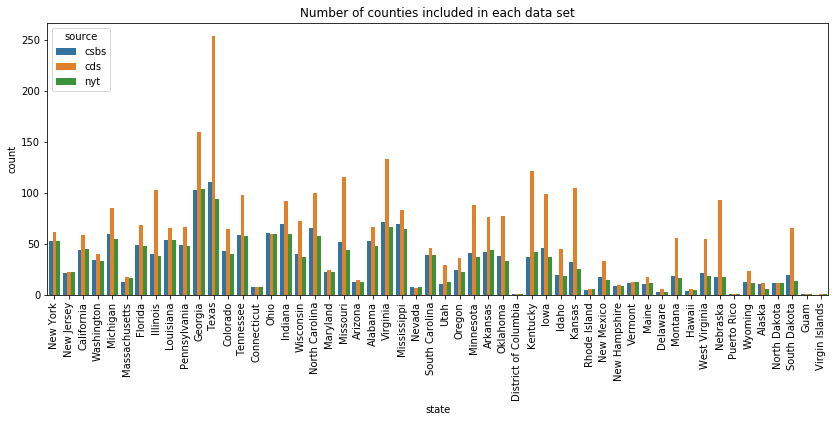

In [11]:
fig = plt.figure(figsize=(14,5))

ax = sns.countplot(
    x="state",
    hue="source",
    data=long_df
)

ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
ax.set(
    title="Number of counties included in each data set"
)
plt.show()

CDS has all counties listed, but many counties have 0 data or have reported 0 cases and were not included in the other datasets.

In [12]:
def plot_county_cases_histogram_by_state() -> None:
    states = long_df["state"].drop_duplicates()

    fig, axs = plt.subplots(18,3, figsize=(15, 40), sharex=True)

    for s, ax in zip(states, axs.ravel()):

        xlim = (0,20)
        long_df_state = long_df.loc[(long_df["state"] == s) & (long_df["cases"] <= xlim[1])] 
        bins=range(0, xlim[1], 1)

        sns.distplot(
            long_df_state.loc[long_df_state["source"] == "cds"]["cases"],
            color=palette["fox"],
            ax=ax,
            kde=False,
            label="cds",
            bins=bins
        )

        sns.distplot(
            long_df_state.loc[long_df_state["source"] == "csbs"]["cases"],
            color=palette["pink"],
            kde=False,
            ax=ax,
            label="csbs",
            bins=bins
        )

        sns.distplot(
            long_df_state.loc[long_df_state["source"] == "nyt"]["cases"],
            color=palette["royal"],
            kde=False,
            ax=ax,
            label="nyt",
            bins=bins
        )

        ax.set(
            xlim=xlim,
            xlabel=None,
            title=s
        )

    fig.text(0.5, 0.11, 'cases', ha='center')
    plt.legend()
    plt.show()

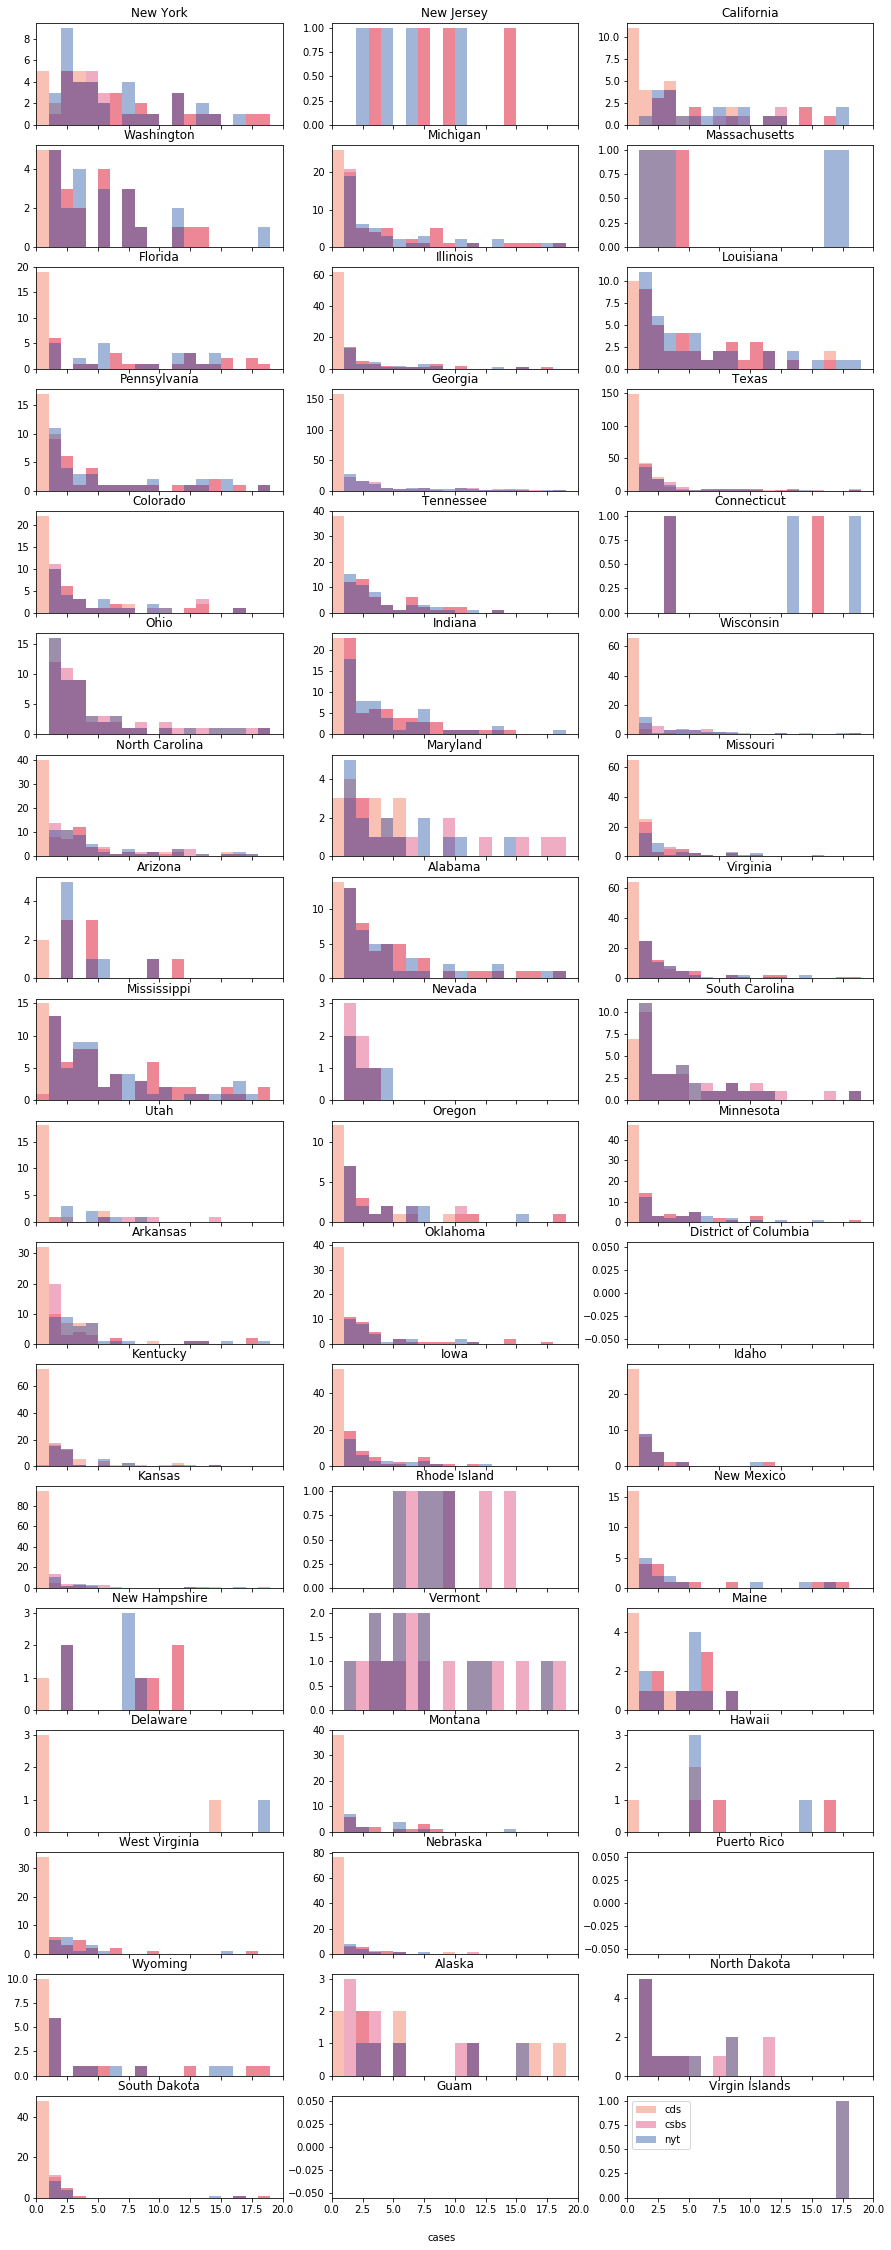

In [13]:
plot_county_cases_histogram_by_state()

In [14]:
def plot_counties_with_data(states=None) -> None:
    
    fig = plt.figure(figsize=(16,5))

    to_plot = long_df.loc[long_df["cases"] > 0]
    
    if states:
        to_plot = to_plot.loc[to_plot["state"].isin(states)]
        
    ax = sns.countplot(
        x="state",
        hue="source",
        data=to_plot
    )

    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
    ax.set(
        title="Number of counties in each data set with recorded cases"
    )
    plt.show()

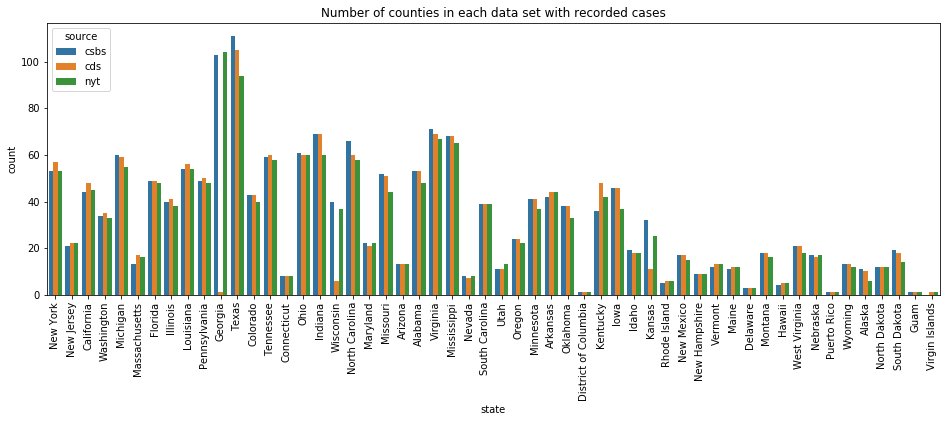

In [15]:
plot_counties_with_data()

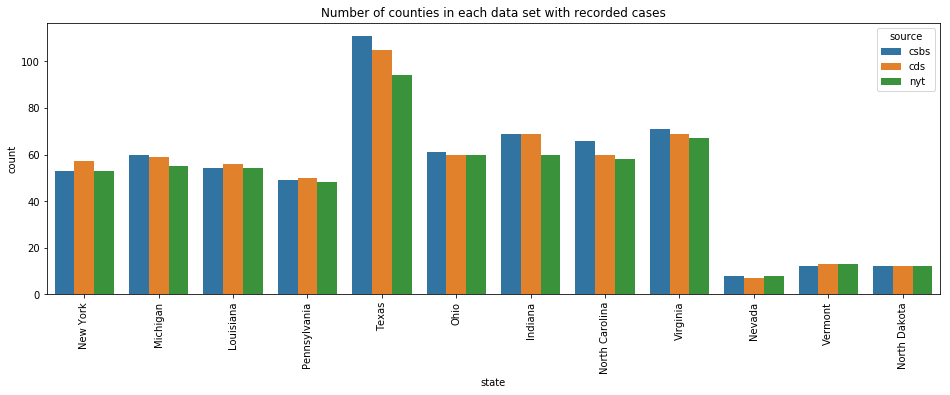

In [16]:
# highlighting the differences
plot_counties_with_data(["New York", "Michigan", "Louisiana", "Pennsylvania",
                        "Texas", "Ohio", "North Carolina", "Indiana", "Nevada", "Virginia",
                        "Vermont", "North Dakota"])

### How similar are the reported county case counts?
Try saying that 3 times fast... "county case counts, county case counts, county case counts..."

In [17]:
# spot check
wide_df.loc[wide_df["state"] == "New Jersey"].sort_values("county")

,county,state,cases_csbs,deaths_csbs,recovered_csbs,tested,active,population,rating,last_updated,cases_cds,deaths_cds,recovered_cds,date,fips,cases_nyt,deaths_nyt
27,(unassigned),New Jersey,1478.0,7.0,NaN,NaN,NaN,NaN,0.627451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1966,Atlantic,New Jersey,14.0,NaN,NaN,NaN,NaN,265429.0,0.411765,2020-03-27T23:57:00Z,14.0,0.0,0.0,2020-03-26,34001.0,10.0,0.0
1967,Bergen,New Jersey,1505.0,NaN,NaN,NaN,NaN,936692.0,0.411765,2020-03-27T23:57:00Z,1505.0,6.0,0.0,2020-03-26,34003.0,1206.0,21.0
1968,Burlington,New Jersey,88.0,NaN,NaN,NaN,NaN,445384.0,0.411765,2020-03-27T23:57:00Z,88.0,0.0,0.0,2020-03-26,34005.0,64.0,3.0
1969,Camden,New Jersey,95.0,NaN,NaN,NaN,NaN,507078.0,0.411765,2020-03-27T23:57:00Z,95.0,1.0,0.0,2020-03-26,34007.0,73.0,1.0
1970,Cape May,New Jersey,7.0,NaN,NaN,NaN,NaN,92560.0,0.411765,2020-03-27T23:57:00Z,7.0,0.0,0.0,2020-03-26,34009.0,6.0,0.0
1971,Cumberland,New Jersey,9.0,NaN,NaN,NaN,NaN,150972.0,0.411765,2020-03-27T23:57:00Z,9.0,0.0,0.0,2020-03-26,34011.0,4.0,1.0
1972,Essex,New Jersey,826.0,NaN,NaN,NaN,NaN,799767.0,0.411765,2020-03-27T23:57:00Z,826.0,4.0,0.0,2020-03-26,34013.0,609.0,15.0
1973,Gloucester,New Jersey,40.0,NaN,NaN,NaN,NaN,291408.0,0.411765,2020-03-27T23:57:00Z,40.0,0.0,0.0,2020-03-26,34015.0,33.0,0.0
1974,Hudson,New Jersey,594.0,NaN,NaN,NaN,NaN,676061.0,0.411765,2020-03-27T23:57:00Z,594.0,2.0,0.0,2020-03-26,34017.0,441.0,4.0


In [18]:
def get_county_case_comparison(states=None) -> None:
    """Compare the reported number of confirmed covid cases between the csbs, cds, and nyt datasets"""
    
    if not states:
        states = wide_df["state"].drop_duplicates()
    elif isinstance(states, str):
        states = [states]
        
    for s in states:
    
        plt.figure(figsize=(15,5))
        to_plot = wide_df.loc[wide_df["state"] == s]
        to_plot["cases_avg"] = to_plot[["cases_csbs","cases_cds","cases_nyt"]].mean(axis=1)
        to_plot = to_plot.sort_values("cases_avg", ascending=True).tail(15)

        i_range = range(1, to_plot.shape[0]+1)
        plt.hlines(
            y=i_range, 
            xmin=to_plot[["cases_csbs","cases_cds","cases_nyt"]].min(axis=1), 
            xmax=to_plot[["cases_csbs","cases_cds","cases_nyt"]].max(axis=1), 
            color='grey', alpha=0.4)
        plt.scatter(to_plot['cases_csbs'], i_range, alpha=1, label='csbs')
        plt.scatter(to_plot['cases_cds'], i_range, alpha=1 , label='cds')
        plt.scatter(to_plot['cases_nyt'], i_range, alpha=1 , label='nyt')
        plt.legend()

        # Add title and axis names
        plt.yticks(i_range, to_plot['county'])
        plt.title(f"{s}: Confirmed Cases Comparison")
        plt.xlabel('Confirmed Covid Cases')
        plt.ylabel('County')
        plt.show()



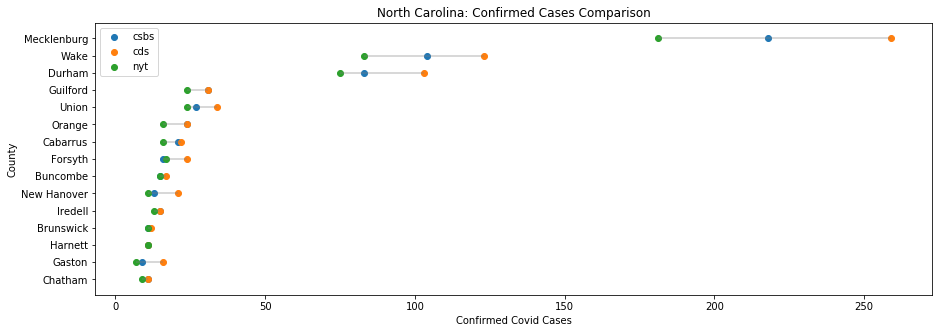

In [19]:
get_county_case_comparison("North Carolina")

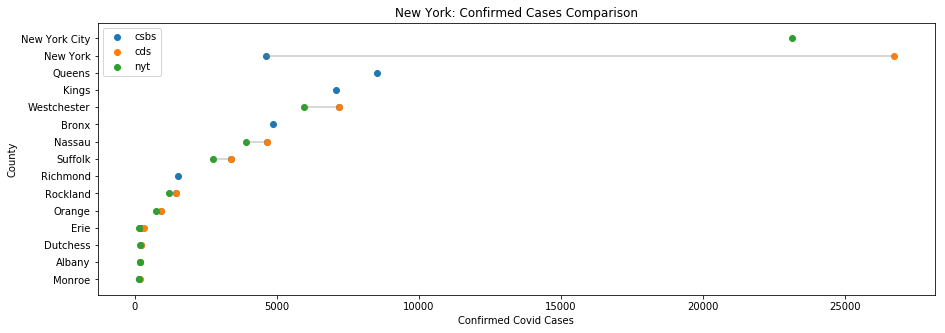

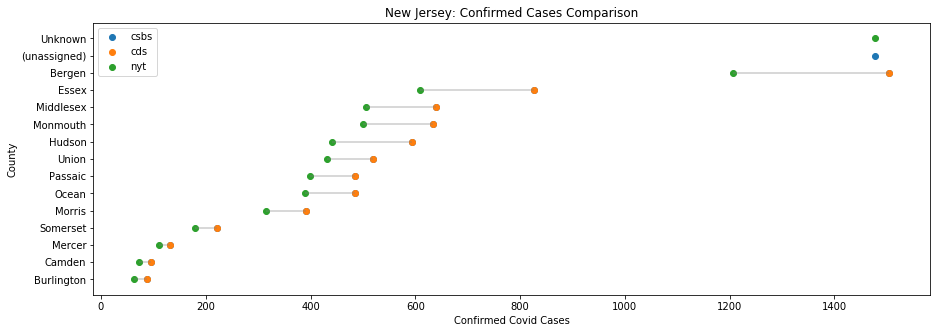

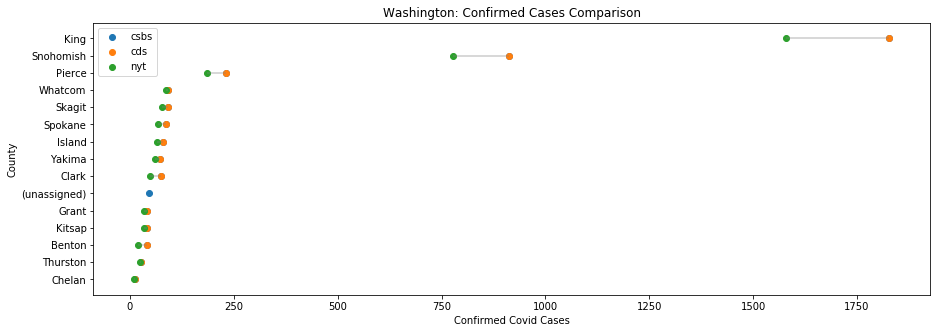

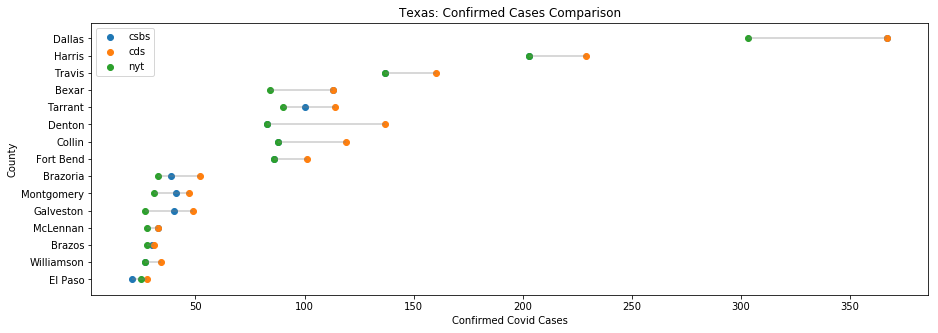

In [20]:
get_county_case_comparison(["New York","New Jersey","Washington","Texas"])

### Are the county numbers rolling up nicely to the reported state numbers?

In [21]:
rollup_df = long_df \
    .groupby(["source", "state"])["cases"] \
    .sum() \
    .reset_index(name="county_rollup_positive")
rollup_df = rollup_df \
    .merge(states[["state", "positive"]], how="left", on="state") \
    .rename(columns={"positive":"state_positive"})

In [22]:
def get_state_rollup_comparison(sources=None, log=False) -> None:
    """Compare how accurately the csbs, cds, and nyt county datasets roll up into the state numbers"""
    
    sns.set_context("notebook", font_scale=1.2)
    sns.set_style("whitegrid")

    if not sources:
        sources = rollup_df["source"].drop_duplicates()
    elif isinstance(sources, str):
        sources = [sources]

    for s in sources:
    
        plt.figure(figsize=(9,20))
        to_plot = rollup_df.loc[rollup_df["source"] == s]
        to_plot = to_plot.sort_values("state_positive", ascending=True)
        
        if log:
            to_plot["county_rollup_positive"] = np.log10(to_plot["county_rollup_positive"])
            to_plot["state_positive"] = np.log10(to_plot["state_positive"])

        i_range = range(1, to_plot.shape[0]+1)
        plt.hlines(
            y=i_range, 
            xmin=to_plot[["county_rollup_positive","state_positive"]].min(axis=1), 
            xmax=to_plot[["county_rollup_positive","state_positive"]].max(axis=1), 
            color='black', alpha=0.4)
        plt.scatter(to_plot['county_rollup_positive'], i_range, alpha=.6, color=palette["fox"], label='county rollup positives')
        plt.scatter(to_plot['state_positive'], i_range, alpha=.8, color=palette["grey"], label='state positives')
        plt.legend()

        # Add title and axis names
        plt.yticks(i_range, to_plot['state'])
        plt.title(f"{s.upper()}: Error between county reported cases and state totals")
        
        plt.ylabel('State')
        sns.despine(left=True)
        if log:
            plt.legend(bbox_to_anchor=(.45, .95))
            plt.xlabel('log(Confirmed Covid Cases)')
        else:
            plt.legend(bbox_to_anchor=(.99, .92))
            plt.xlabel('Confirmed Covid Cases')
        plt.show()

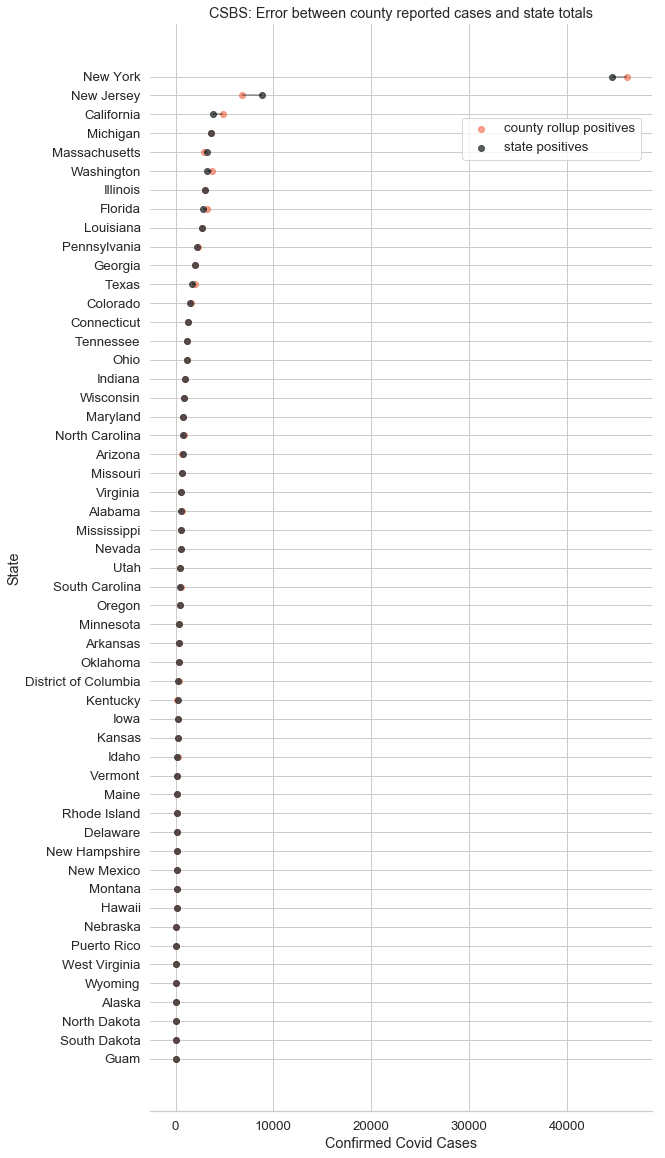

In [23]:
get_state_rollup_comparison("csbs")

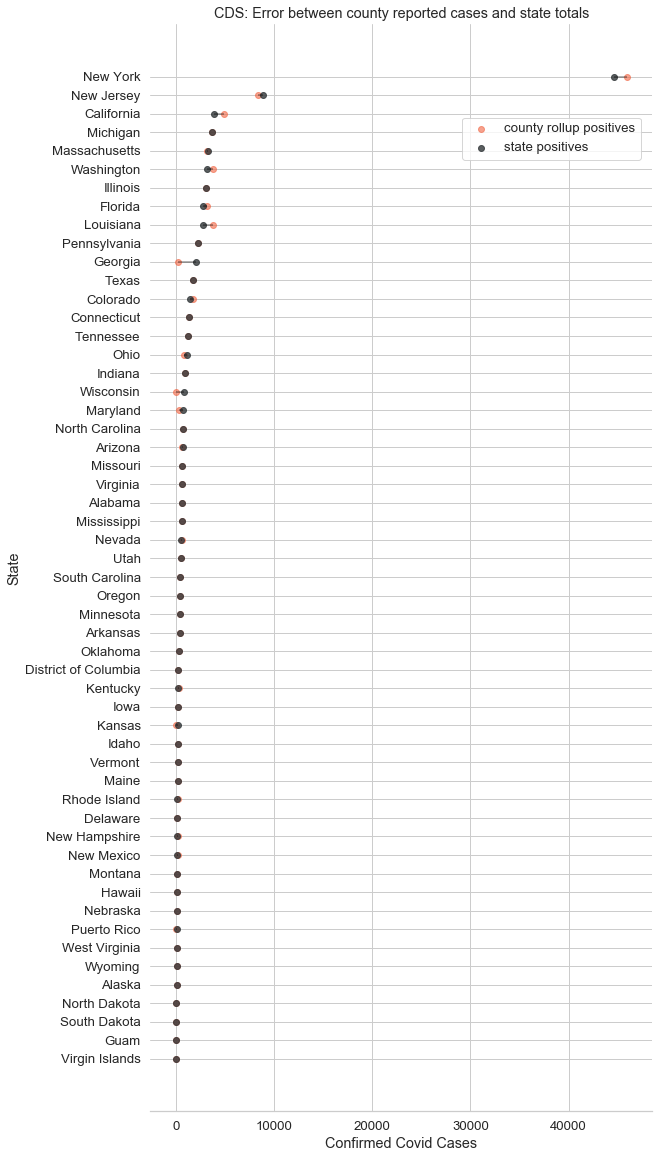

In [24]:
get_state_rollup_comparison("cds")

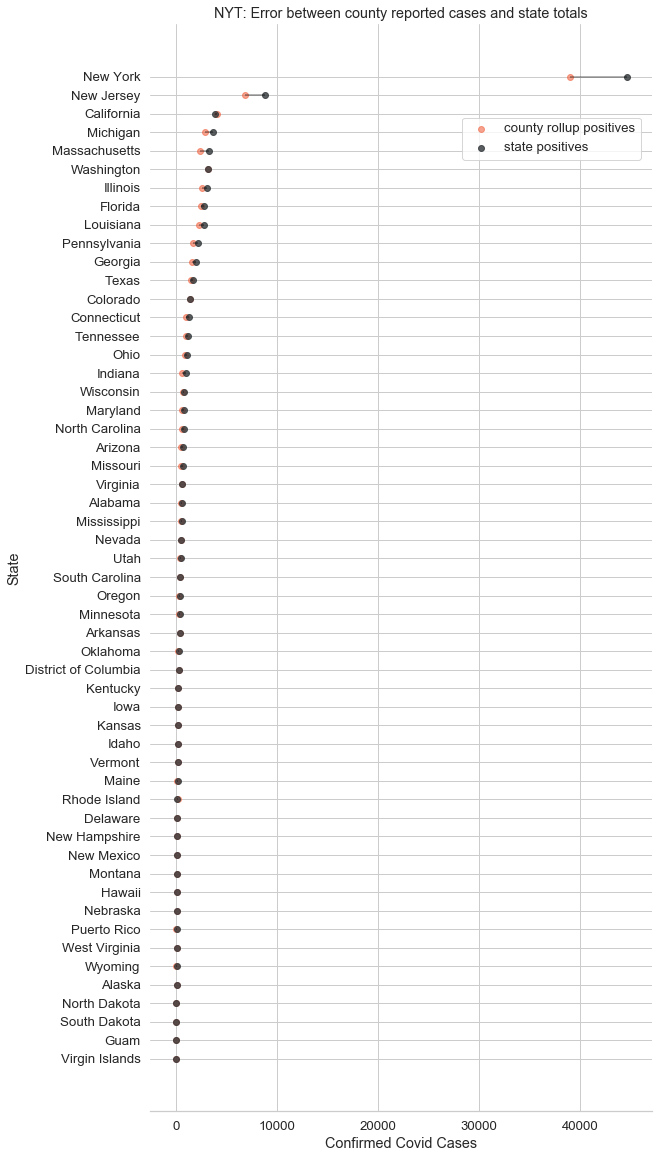

In [25]:
get_state_rollup_comparison("nyt")

For comparison sake, it might be helpful to look at this on a log scale 

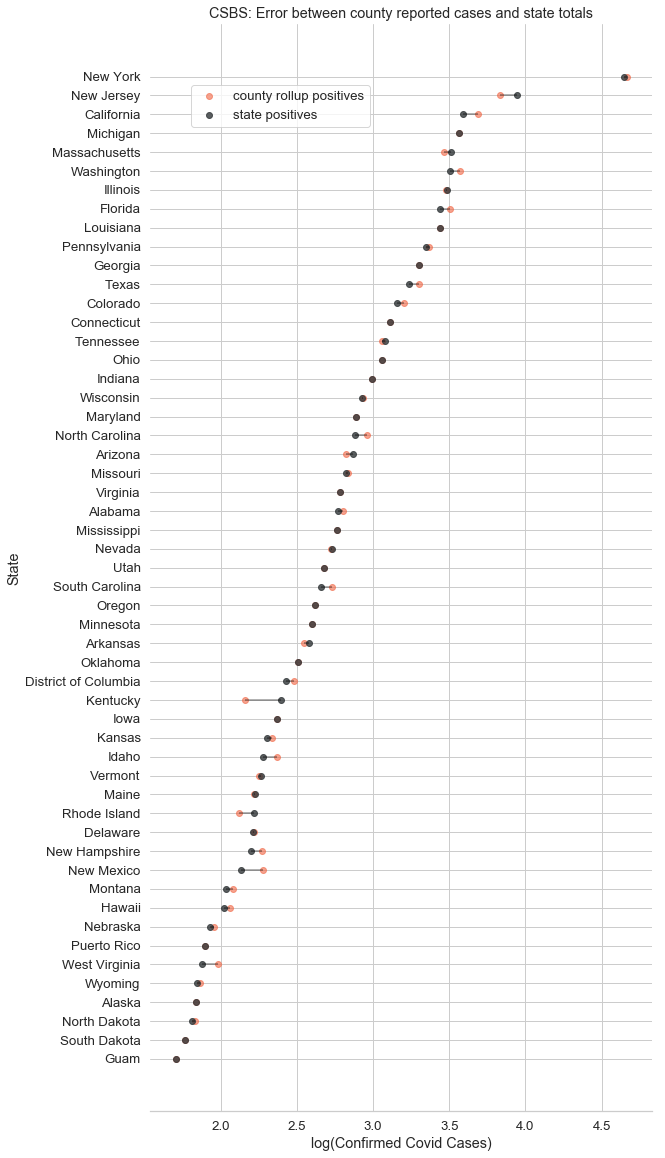

In [26]:
get_state_rollup_comparison(sources="csbs", log=True)

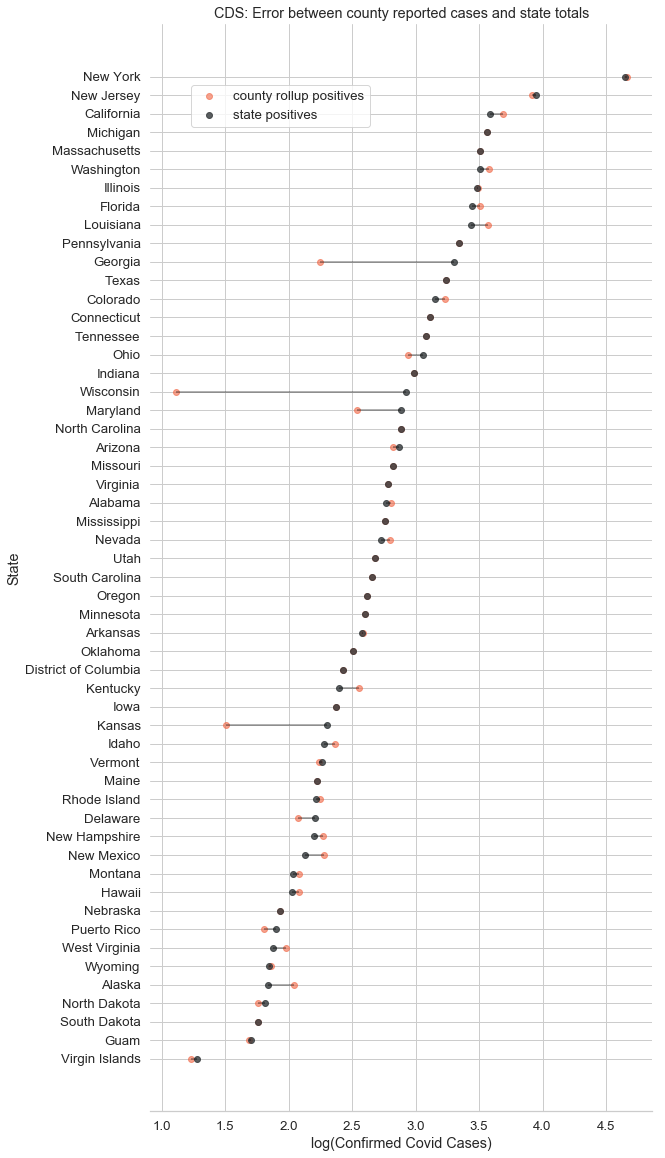

In [27]:
get_state_rollup_comparison(sources="cds", log=True)

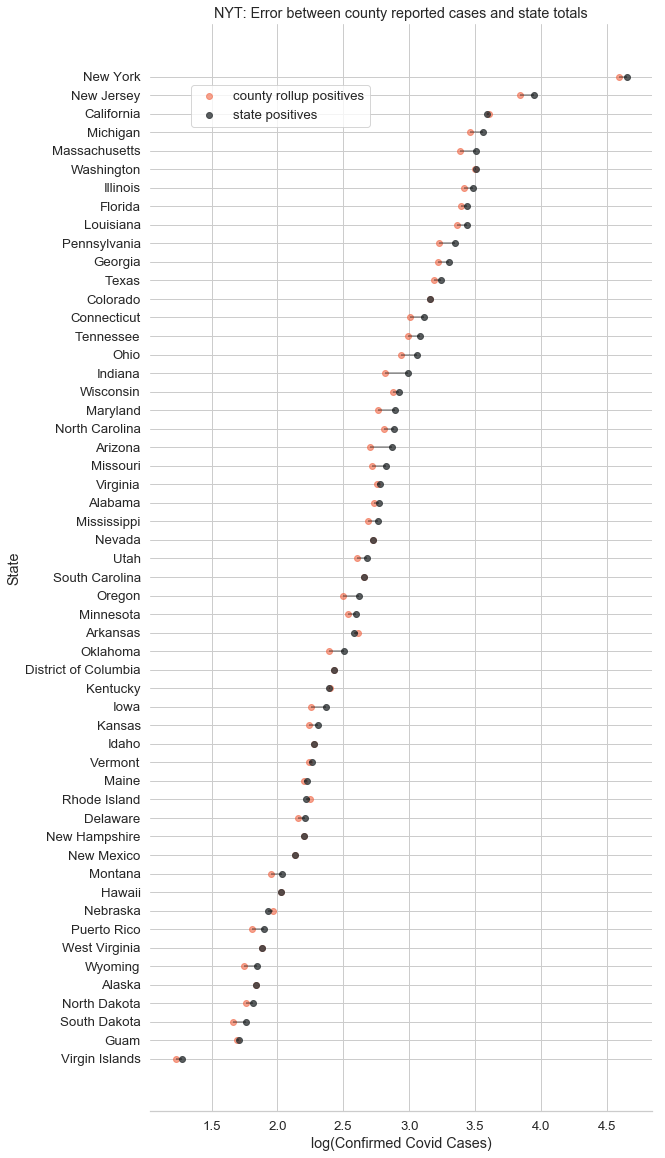

In [28]:
get_state_rollup_comparison(sources="nyt", log=True)